# Exercises 03: Deep Learning
*Link to slides: <https://bit.ly/2Vqx3kO>*

### Important Note: Enabling GPU
To make sure this is enabled, go to the "Runtime" menu at the top of the page, and click select the "Change Runtime Type" option. Under "Hardware Accelerator", choose "GPU" and then hit "Save". 

In [1]:
import itertools

import argparse
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
LEARNING_RATE = 1
GAMMA = 0.7
RANDOM_SEED = 1

#################################
# Input:
Images is tensor of shape: torch.Size([64, 1, 28, 28]), labels is tensor of shape: torch.Size([64])
Images:


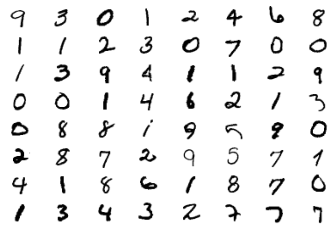

Labels:
9,3,0,1,2,4,6,8,
1,1,2,3,0,7,0,0,
1,3,9,4,1,1,2,9,
0,0,1,4,6,2,1,3,
0,8,8,1,9,5,9,0,
2,8,7,2,9,5,7,1,
4,1,8,6,1,8,7,0,
1,3,4,3,2,7,7,7,


In [3]:
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)

print("#################################")
print("# Input:")

train_iter = iter(train_loader)
test_iter = iter(test_loader)
images, labels = train_iter.next()
print(f'Images is tensor of shape: {images.shape}, labels is tensor of shape: {labels.shape}')
figure = plt.figure()
num_of_images = 64
for index in range(1, num_of_images + 1):
    plt.subplot(8, 8, index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')
print("Images:")
plt.show()
print("Labels:")
for i in range(8):
    for j in range(8):
        print(labels[i*8+j].item(), end=',')
    print()

In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [5]:
model = Model().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE)

#################################
# Training:
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.299167
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.216652
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.181471
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.232099
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.098141
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.260788
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.105642
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.116431
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.246239
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.193935

Test set: Average loss: 902.3699, Accuracy: 9730/10000 (97%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


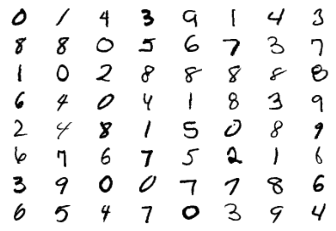

Preds:
0,1,4,3,9,1,4,3,
8,8,0,5,6,7,3,7,
1,0,2,8,8,8,8,0,
6,4,0,4,1,8,3,9,
2,4,8,1,5,0,8,9,
6,7,6,7,5,2,1,6,
3,9,0,0,7,7,8,6,
6,5,4,7,0,3,9,4,


In [6]:
EPOCHS = 1
ITER_PER_EPOCH = 1000
TEST_ITER_PER_EPOCH = len(test_loader)
LOG_INTERVAL = 100

print("#################################")
print("# Training:")

for epoch in range(EPOCHS):
    train_iter = itertools.cycle(iter(train_loader))
    test_iter =  iter(test_loader)

    for batch_idx in range(ITER_PER_EPOCH):
        (data, target) = next(train_iter)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    test_loss = 0
    total = 0
    correct = 0
    images = None
    preds = None
    with torch.no_grad():
        for batch_idx in range(TEST_ITER_PER_EPOCH):
            (data, target) = next(test_iter)

            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.shape[0]
            images = data.cpu()
            preds = pred.cpu().numpy()
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, total,
            100. * correct / total))

    print(f'Images is tensor of shape: {images.shape}, preds is tensor of shape: {preds.shape}')
    figure = plt.figure()
    num_of_images = 64
    for index in range(num_of_images):
        plt.subplot(8, 8, index+1)
        plt.axis('off')
        plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
    print("#################################")
    print("# Test Output:")

    print("Images:")
    plt.show()
    print("Preds:")
    for i in range(8):
        for j in range(8):
            print(preds[i*8+j].item(), end=',')
        print()

## Exercise 1
 - Change the above to use [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) as an optimizer
 - Retrain the model
 - How does the accuracy change? Can you improve accuracy by modifying the learning rate?

## Exercise 2
 - Add a plot which shows loss over time
 - Add a second plot which shows test accuracy over time (you can use (correct / total) for your accuracy score
 - Set EPOCHS to 10 and rerun to see how test accuracy increases

## Exercise 3
Try increase / reduce the amount of dropout on the model. How does this affect the accuracy? 